In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import seaborn as sns
import yfinance as yf
import re
import tweetnlp
from tqdm.notebook import tqdm
import torch
from transformers import pipeline
from datasets import Dataset
import ast
from matplotlib.ticker import MaxNLocator
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import random
from PIL import Image

plt.style.use('seaborn-v0_8-pastel')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/yeuf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yeuf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yeuf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv('Twitter Jan Mar.csv')

In [3]:
df.head()

,date,id,content,username,like_count,retweet_count
0,2023-03-29 22:58:21+00:00,1641213230730051584,"Free AI marketing and automation tools, strate...",RealProfitPros,0.0,0.0
1,2023-03-29 22:58:18+00:00,1641213218520481805,@MecoleHardman4 Chat GPT says it’s 15. 😂,AmyLouWho321,0.0,0.0
2,2023-03-29 22:57:53+00:00,1641213115684536323,https://t.co/FjJSprt0te - Chat with any PDF!\n...,yjleon1976,0.0,0.0
3,2023-03-29 22:57:52+00:00,1641213110915571715,"AI muses: ""In the court of life, we must all f...",ChatGPT_Thinks,0.0,0.0
4,2023-03-29 22:57:26+00:00,1641213003260633088,Most people haven't heard of Chat GPT yet.\nFi...,nikocosmonaut,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500036 entries, 0 to 500035
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           500036 non-null  object 
 1   id             500030 non-null  object 
 2   content        500030 non-null  object 
 3   username       500002 non-null  object 
 4   like_count     499974 non-null  float64
 5   retweet_count  499974 non-null  float64
dtypes: float64(2), object(4)
memory usage: 22.9+ MB


In [5]:
df['date'] =  pd.to_datetime(df['date'], errors='coerce')
df['date'] = df['date'].dt.date
df = df.dropna(subset=['date'])
df['date'] = df['date'].astype(str)

In [6]:
def pre_process(text):
    text = re.sub('http://\S+|https://\S+', '', text)
    text = re.sub('http[s]?://\S+', '', text)
    text = re.sub(r"http\S+", "", text)

    text = re.sub('&amp', 'and', text)
    text = re.sub('&lt', '<', text)
    text = re.sub('&gt', '>', text)

# Remove new line characters
    text = re.sub('[\r\n]+', ' ', text)

    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
# Remove multiple space characters
    text = re.sub('\s+',' ', text)
    
    # Convert to lowercase
    text = text.lower()
    return text

In [7]:
df['processed_content'] = df['content'].apply(pre_process)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500002 entries, 0 to 500035
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               500002 non-null  object 
 1   id                 500002 non-null  object 
 2   content            500002 non-null  object 
 3   username           499974 non-null  object 
 4   like_count         499974 non-null  float64
 5   retweet_count      499974 non-null  float64
 6   processed_content  500002 non-null  object 
dtypes: float64(2), object(5)
memory usage: 30.5+ MB


In [11]:
df.columns

Index(['date', 'id', 'content', 'username', 'like_count', 'retweet_count',
       'processed_content'],
      dtype='object')

In [12]:
data_column = df[['id', 'processed_content']]
df_data = data_column.copy()
dataset = Dataset.from_pandas(df_data)

In [15]:
results = {}
model = pipeline(model='cardiffnlp/twitter-roberta-base-sentiment-latest', device=0, batch_size=32)
for row in tqdm(dataset):
    text = row['processed_content']
    id = row['id']
    results[id] = model(text)

Downloading:   0%|          | 0.00/2.77k [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/500002 [00:00<?, ?it/s]

/home/yeuf/miniconda3/envs/nlp_chatGPT/lib/python3.8/site-packages/transformers/pipelines/base.py:1036: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [24]:
roberta_sentiments = pd.DataFrame(results).T
roberta_sentiments = roberta_sentiments.reset_index().rename(columns={'index': 'id'})
roberta_sentiments = roberta_sentiments.merge(df, how='left')
roberta_sentiments.to_csv('Inference_results.csv')

In [3]:
df_results = pd.read_csv('Inference_results.csv')

In [4]:
df_results = df_results.drop('Unnamed: 0', axis=1)
df_results = df_results.rename(columns={'0': 'scores'})
df_results['scores'] = df_results['scores'].map(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_results = pd.concat([df_results.drop(['scores'], axis=1), df_results['scores'].apply(pd.Series)], axis=1)

In [5]:
df_results['date'] = pd.to_datetime(df_results['date'])

df_results['month'] = df_results['date'].dt.month
df_results['day'] = df_results['date'].dt.day

In [53]:
df_results.head()

,id,date,content,username,like_count,retweet_count,processed_content,label,score
0,1641213230730051584,2023-03-29,"Free AI marketing and automation tools, strate...",RealProfitPros,0.0,0.0,"free ai marketing and automation tools, strate...",neutral,0.562645
1,1641213218520481805,2023-03-29,@MecoleHardman4 Chat GPT says it’s 15. 😂,AmyLouWho321,0.0,0.0,chat gpt says it’s 15. 😂,neutral,0.838425
2,1641213115684536323,2023-03-29,https://t.co/FjJSprt0te - Chat with any PDF!\n...,yjleon1976,0.0,0.0,- chat with any pdf! check out how this new a...,positive,0.924208
3,1641213110915571715,2023-03-29,"AI muses: ""In the court of life, we must all f...",ChatGPT_Thinks,0.0,0.0,"ai muses: ""in the court of life, we must all f...",neutral,0.901148
4,1641213003260633088,2023-03-29,Most people haven't heard of Chat GPT yet.\nFi...,nikocosmonaut,0.0,0.0,most people haven't heard of chat gpt yet. fir...,negative,0.780532


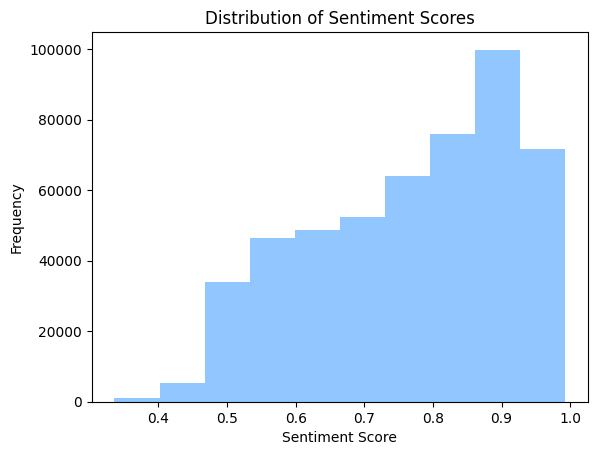

In [58]:
plt.hist(df_results['score'], bins=10)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

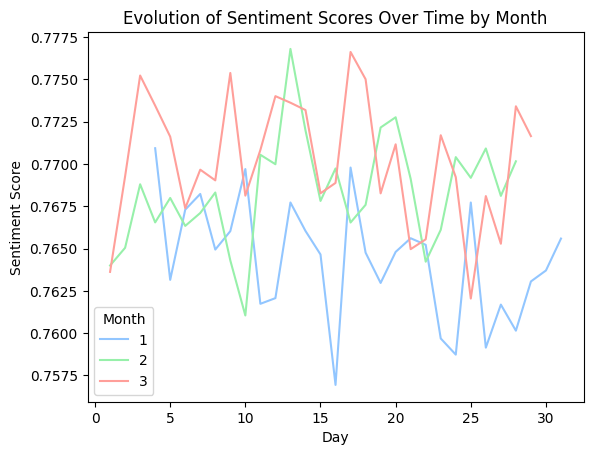

In [106]:
# create a pivot table with the average sentiment score for each day of each month
pivot = pd.pivot_table(df_results, values='score', index='day', columns='month')

# plot the result as a line chart
pivot.plot()
plt.xlabel('Day')
plt.ylabel('Sentiment Score')
plt.title('Evolution of Sentiment Scores Over Time by Month')
plt.legend(title='Month')
plt.show()

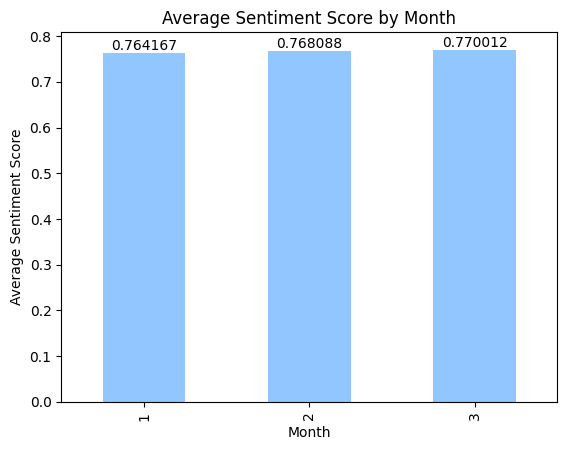

In [73]:
# then, group by month and calculate the average sentiment score for each month
monthly_avg = df_results.groupby('month')['score'].mean()

# plot the result as a bar chart
ax = monthly_avg.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score by Month')
for i in ax.containers:
    ax.bar_label(i)
plt.show()


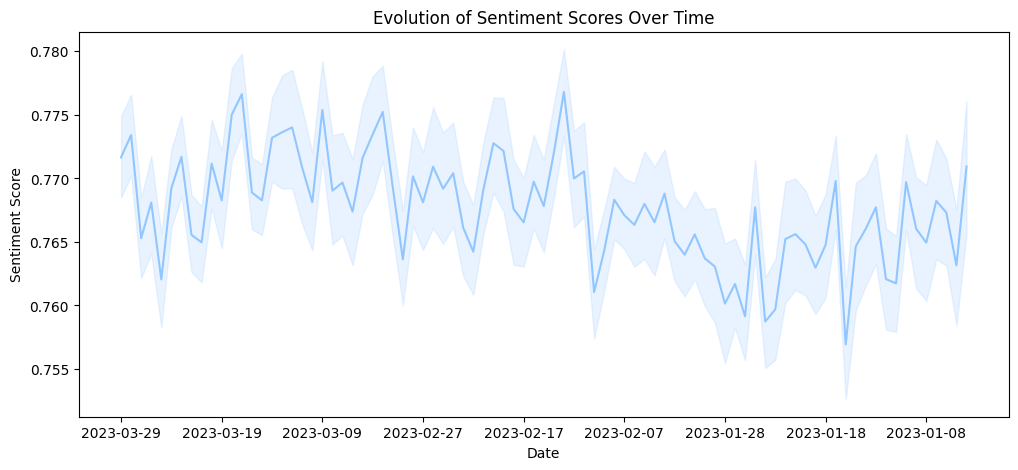

In [96]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(data=df_results, x='date', y='score')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Evolution of Sentiment Scores Over Time')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [29]:
tweets_by_day = df_results.groupby(pd.Grouper(key='date', freq='D')).size().reset_index()
tweets_by_day.columns = ['date', 'count']
fig2 = px.bar(tweets_by_day, x='date', y='count', title='Number of Tweets per Day', color = 'count', height=800, width=1300)
fig2.update_xaxes(tickangle=45, tickformat='%Y-%m-%d')
fig2.show()

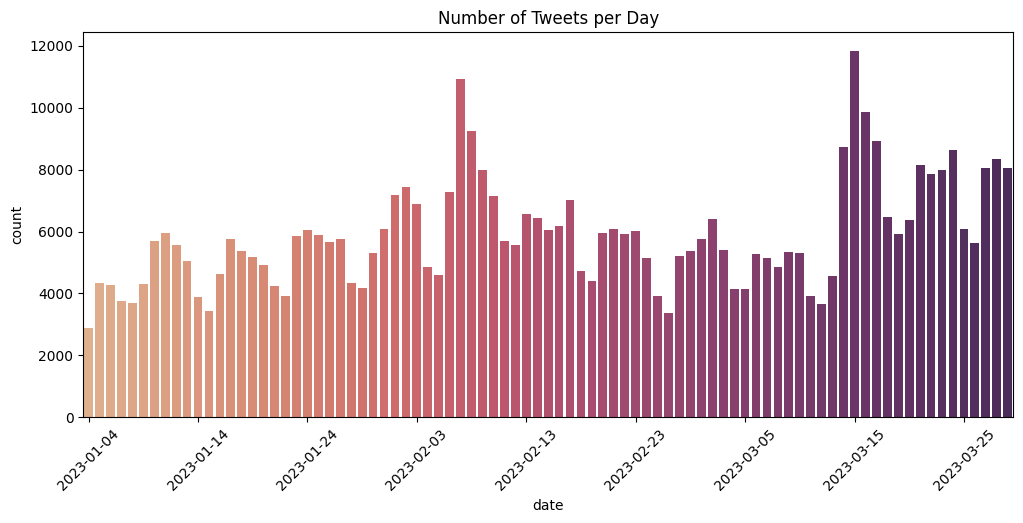

In [32]:
tweets_by_day['date'] = pd.to_datetime(tweets_by_day['date']).dt.date
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.barplot(data=tweets_by_day, x='date', y='count', palette='flare')
plt.title('Number of Tweets per Day')
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

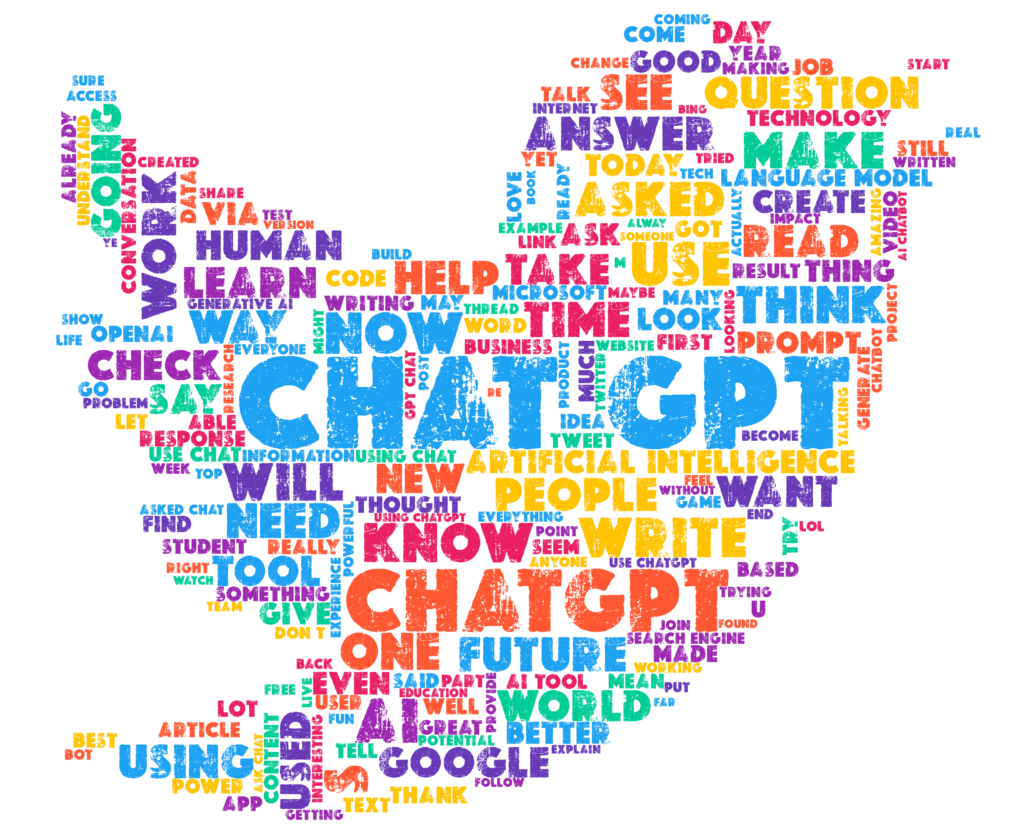

In [21]:
wordnet_lem = WordNetLemmatizer()

df_results['content_lem'] = df_results['processed_content'].apply(wordnet_lem.lemmatize)
all_words_lem = ' '.join([word for word in df_results['content_lem']])


def multi_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    colors = ['#1DA1F2', '#00CC96', '#FF5733', '#FFC300', '#E91E63', '#9C27B0', '#673AB7']
    return random.choice(colors)

mask = np.array(Image.open("Wordcloud_content/twitter_logo1.png"))
stopwords = set(STOPWORDS)

wordcloud_twitter = WordCloud(height=2000, width=2000,
                              background_color="white", mode="RGBA",
                              stopwords=stopwords, mask=mask, color_func=multi_color_func,
                              font_path='Wordcloud_content/TheGlobePersonalUseBold-2ORlw.ttf').generate(all_words_lem)

plt.figure(figsize=[10, 10])
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud_twitter.recolor(color_func=multi_color_func), interpolation="bilinear")
plt.savefig("twitter_wordcloud.png", format="png")

plt.show()